# Stats and Sleep
Tushar Chandra -- STATS 383 final project

This notebook contains my final project for STATS 383 (Statistics for ISP) at Northwestern Unviersity. In it, I investigate several questions about my sleep habits using data collected from my Fitbit. 

## 1. Introduction
### Data Sources
The data used in this notebook was collected on my Fitbit Charge HR nightly since July 2015. To access the data, I wrote a Python script to download all of my sleep data from Fitbit, using their API. The script requested each day's worth of data, and stored the API response in log files named as `yyyy-mm-dd.json`. For more information on this, see the script `fitbit.py` and the README in the home directory of my repo `sleep-analysis`.

### Questions of Interest
In this notebook, I will answer the following questions using statistical methods from class:
 * Something
 * Something else!
 
### Setup
Let's setup the notebook by importing useful packages and configuring plots.

In [147]:
%matplotlib inline

from collections import namedtuple
import datetime
import json

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [9.0, 6.0]

### Data Format
Before jumping in, let's run some illustrative commands to better understand the shape of the data. One can refer to the [Fitbit documentation](https://dev.fitbit.com/docs/sleep/) for details about the log files' contents. Each day contains two top-level attributes, `sleep` and `summary`:
 * `sleep` is a list of one or more sleep events in a day. Each entry has several attributes, like `isMainSleep` and `minutesAsleep`. In addition, `minuteData.minuteData` contains minute-by-minute sleep data, where each minute has an identifier, 1, 2, or 3, denoting asleep, restless, or awake, respectively.
 * `summary` contains aggregate statistics -- it includes the number of sleep events (`totalSleepRecords`), the total time spent in bed (`totalTimeInBed`), and total time asleep (`TotalMinutesAsleep`).

In [22]:
# This should get the top-level keys 'summary' and 'sleep'
with open('logs/2017-02-01.json') as f:
    sample_data = json.loads(f.read())
    
list(sample_data.keys())

['sleep', 'summary']

In [25]:
# This should get the summary statistics available
list(sample_data['summary'].keys())

['totalSleepRecords', 'totalTimeInBed', 'totalMinutesAsleep']

In [24]:
# This should get the keys for the first sleep entry (isMainSleep, minutesAsleep, etc.)
list(sample_data['sleep'][0].keys())

['duration',
 'minutesAwake',
 'minutesAfterWakeup',
 'restlessCount',
 'restlessDuration',
 'minutesAsleep',
 'startTime',
 'logId',
 'efficiency',
 'timeInBed',
 'awakeCount',
 'isMainSleep',
 'dateOfSleep',
 'minutesToFallAsleep',
 'awakeDuration',
 'awakeningsCount',
 'minuteData']

In [28]:
# This will tell me the number of minutes I spent in bed that night
sample_data['summary']['totalTimeInBed']

215

Note that the sleep record for a particular day contains data from the previous night, not the following night. That is, the data in `2017-02-01.json` will tell me how much I slept the night after January 31st.

## 2. Time spent asleep during winter quarter
I will first study how my sleep habits changed over winter quarter 2017. To do this, I'll obtain time-series data of how much time I was in bed versus day in the quarter, and perform regression analysis on it to see if there is a statistically significant slope. Seeing such a slope would indicate that how much I slept changed in some way throughout winter.

### Obtaining Data
First, obtain the relevant data. Winter quarter started on January 3rd, and has not yet ended, so we use the date of writing as the last date of analysis.

We are interested in the total time spent in bed during winter. However, I want to study how much time I spent asleep at night, without considering naps. Because of this, I'll only look at the events where `isMainSleep` is `true`.

In [180]:
# Dates of interest, and NamedTuple to hold relevant info
dates = pd.date_range("2017-01-03", "2017-03-15")

data = []

# Obtain time spent in bed and bedtime for each main sleep event
for date in dates:
    fname = 'logs/' + date.strftime('%Y-%m-%d') + '.json'
    with open(fname, "r") as f:
        date_data = json.loads(f.read())
        
        for sleep_event in date_data["sleep"]:
            if sleep_event["isMainSleep"]:
                data.append(sleep_event["timeInBed"])

# Convert to Pandas dataframe
df = pd.DataFrame(data, columns = ["duration"], index = dates)

Let's clean this a little. Add a column for the number of days since the start of winter (this will make regression much easier). Convert the durations from minutes to hours. Finally, treat bedtime as a decimal (e.g., 5:30 -> 5.5). We can look at the first few entries to get a feel for the data.

In [181]:
df["date_delta"] = (df.index - dates.min())  / np.timedelta64(1,'D')
df["duration"] /= 60

df.head()

,duration,date_delta
2017-01-03,6.033333,0.0
2017-01-04,6.566667,1.0
2017-01-05,8.016667,2.0
2017-01-06,5.733333,3.0
2017-01-07,10.850000,4.0


We'll plot the data, do a linear regression, and look at the results.

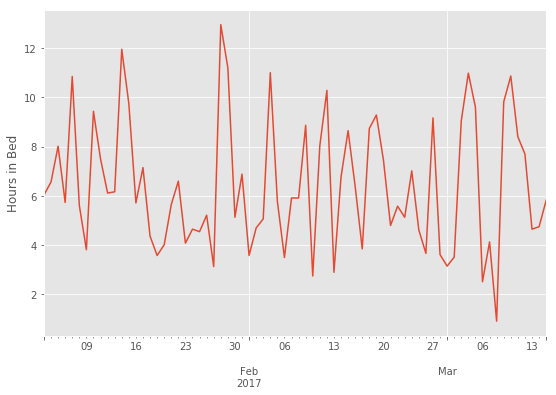

In [182]:
df["duration"].plot()
plt.ylabel("Hours in Bed");

In [183]:
# Create a fitted model for duration vs. date
model = smf.ols(formula = 'duration ~ date_delta', data = df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.6769,0.619,10.783,0.000,5.442,7.912
date_delta,-0.0076,0.015,-0.505,0.615,-0.038,0.022


In [184]:
model.rsquared

0.0036270189954078491

The confidence interval for the linear coefficient is (-0.038, 0.022), which includes zero; likewise, the p-value is 0.615. We d not conclude there is a significant trend in my sleep duration over the course of the quarter. Indeed, we can see this from the line graph above -- the plot is very noisy and it's hard to tell much of a difference. We can also graph the predicted line against the actual data (as a scatterplot, this time, for readability) to see this.

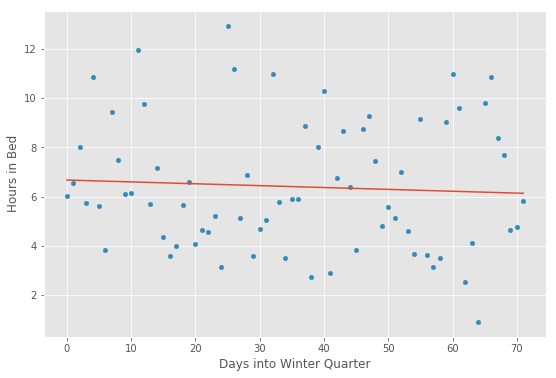

In [186]:
# Make predictions for the lowest and highest dates, then interpolate
date_bounds = pd.DataFrame({"date_delta": [df.date_delta.min(), df.date_delta.max()]})
preds = model.predict(date_bounds)

# Plot the durations, then the predictions
df.plot.scatter(x = "date_delta", y = "duration")
plt.plot(date_bounds, preds)
plt.xlabel("Days into Winter Quarter")
plt.ylabel("Hours in Bed");

Still, though, we are interested in longer-term trends in this data. Let's try to do a moving average of my hours spent asleep. We can do this with the `rolling()` method of a timeseries.

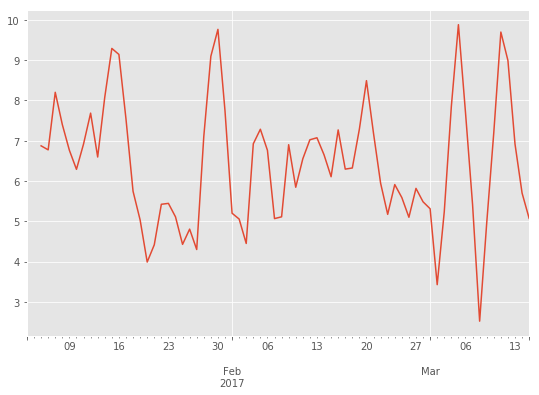

In [192]:
df.duration.rolling(center=False,window=3).mean().plot()

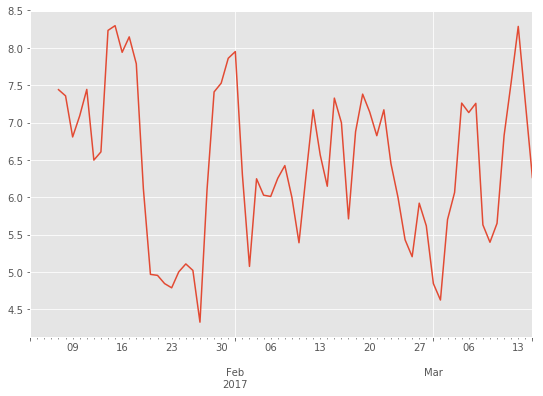

In [194]:
df.duration.rolling(center=False,window=5).mean().plot()